In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

# Load images in RAM (MNIST)
X_flat, y = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto', return_X_y=True)
y = y.astype(int)
images = X_flat.reshape(-1, 28, 28).astype(np.uint8)

In [2]:
N_SAMPLES = 200  # number of MNIST images to use

# Limit dataset
images_sample, y_sample = images[:N_SAMPLES], y[:N_SAMPLES]

## Baseline: pixels

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from joblib import Parallel, delayed
import numpy as np

def cross_validation_parallel(feature_extractor, images, y):
    # Parallel feature extraction across all CPU cores
    X = Parallel(n_jobs=16, prefer="threads")(delayed(feature_extractor)(im) for im in images)
    X = np.vstack(X)
    print("Shape of the feature matrix:", X.shape)

    # classifier + CV
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(clf, X, y, cv=cv, scoring=["accuracy", "f1_weighted"], n_jobs=-1, return_estimator=False)

    acc_folds = scores["test_accuracy"]        # shape (5,)
    f1w_folds = scores["test_f1_weighted"]     # shape (5,)

    print("Done with feature computation, starting classifier")
    print(f"Accuracy:  {acc_folds.mean():.4f} ± {acc_folds.std():.4f}  | folds: {acc_folds}")
    print(f"F1-weight: {f1w_folds.mean():.4f} ± {f1w_folds.std():.4f} | folds: {f1w_folds}")
    return X
def get_raw_pixels(img):
    return np.asarray(img, dtype=np.float32).ravel()

cross_validation_parallel(get_raw_pixels, images_sample, y_sample)

Shape of the feature matrix: (200, 784)
Done with feature computation, starting classifier
Accuracy:  0.8050 ± 0.0485  | folds: [0.825 0.725 0.8   0.875 0.8  ]
F1-weight: 0.7966 ± 0.0492 | folds: [0.81583333 0.71693362 0.80515873 0.8672619  0.77805195]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(200, 784), dtype=float32)

## Baseline: persistent homology (persistence image)

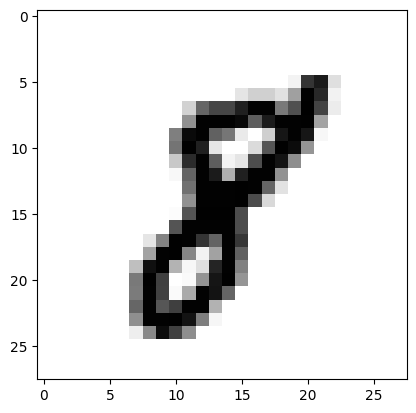

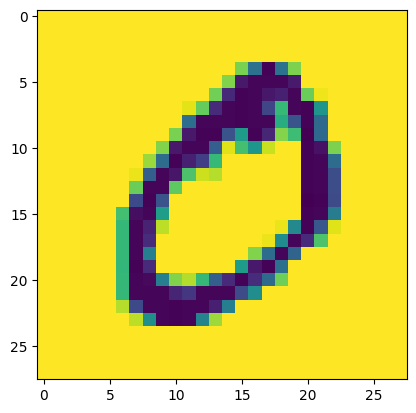

In [20]:
import matplotlib.pyplot as plt
img_8 = images_sample[17].astype(float)
img_8 = 255.0 - img_8  # superlevel via negation
plt.imshow(img_8, cmap='gray')
plt.figure()
img_0 = images_sample[1].astype(float)
img_0 = 255.0 - img_0  # superlevel via negation
plt.imshow(img_0)

/home/marmas/personal/repos/persistent-laplacians/.venv/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

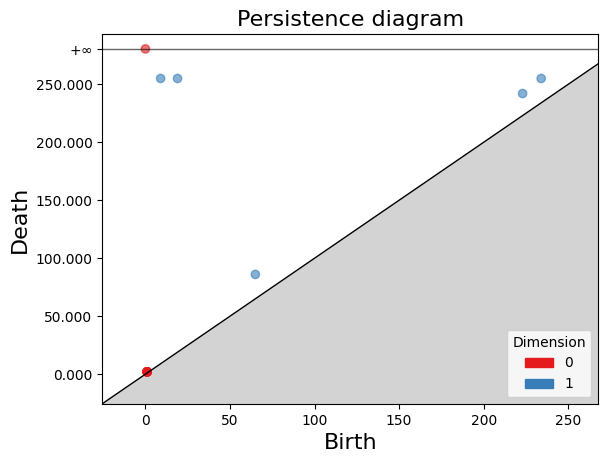

<Figure size 640x480 with 0 Axes>

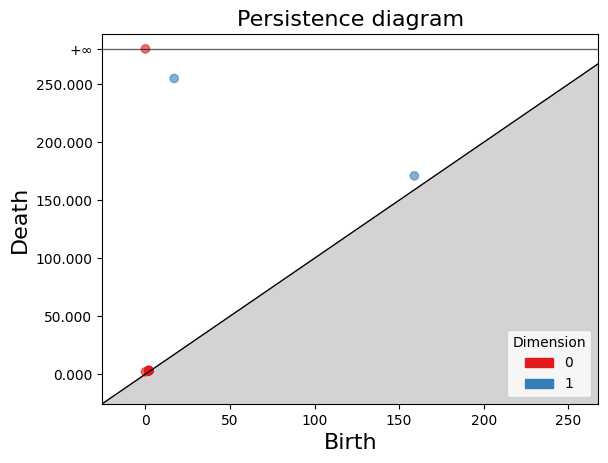

In [5]:
import gudhi as gd

complex_8 = gd.CubicalComplex(top_dimensional_cells=img_8)
dgmX = complex_8.persistence()
gd.plot_persistence_diagram(dgmX)
plt.figure()
complex_0 = gd.CubicalComplex(top_dimensional_cells=img_0)
dgmX = complex_0.persistence()
gd.plot_persistence_diagram(dgmX)

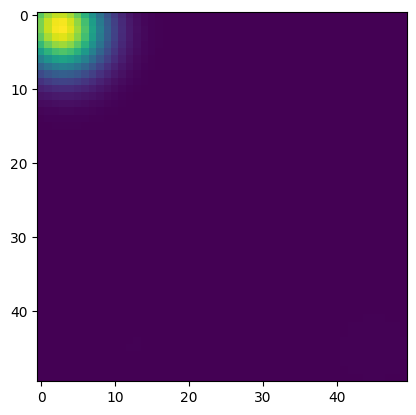

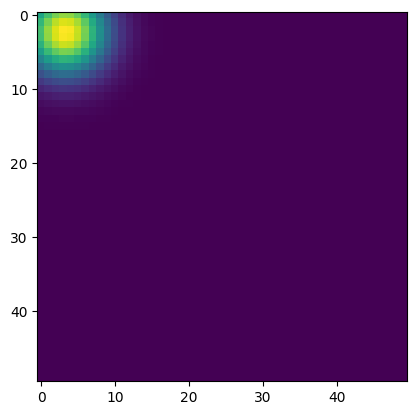

In [6]:
# testing persistence image from Gudhi
import gudhi.representations
import matplotlib.pyplot as plt

# 8
persistence_image_constructor = gd.representations.PersistenceImage(bandwidth=20, resolution=[50, 50], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
persistence_image = persistence_image_constructor.fit_transform([complex_8.persistence_intervals_in_dimension(1)])
plt.imshow(np.flip(np.reshape(persistence_image, [50,50]), 0))

plt.figure()

# 0
persistence_image_constructor = gd.representations.PersistenceImage(bandwidth=20, resolution=[50, 50], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
persistence_image = persistence_image_constructor.fit_transform([complex_0.persistence_intervals_in_dimension(1)])
plt.imshow(np.flip(np.reshape(persistence_image, [50,50]), 0))

In [51]:
import gudhi as gd
import gudhi.representations
def persistence_image_dim_1(image):
    image = 255.0 - image
    complex = gd.CubicalComplex(top_dimensional_cells=image)
    complex.compute_persistence()
    PI =  gd.representations.PersistenceImage(bandwidth=20, resolution=[50,50], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
    pi = PI.fit_transform([complex.persistence_intervals_in_dimension(1)])
    return pi.flatten()

X_dim1 = cross_validation_parallel(persistence_image_dim_1, images_sample, y_sample)

Shape of the feature matrix: (200, 2500)
Done with feature computation, starting classifier
Accuracy:  0.2850 ± 0.0490  | folds: [0.3   0.2   0.275 0.35  0.3  ]
F1-weight: 0.2220 ± 0.0568 | folds: [0.22071429 0.11875    0.23656205 0.2913961  0.24244306]


This is actually exactly as expected if only using 1st homology: groups {0, 6, 9}, {8}, {1,2,3,4,5,7} are classified, 
so classification accuracy is $$\frac{3}{10} \cdot \frac{1}{3} + \frac{1}{10} \cdot 1 + \frac{6}{10} \cdot \frac{1}{6} = 0.3, $$ assuming uniform distribution of numbers in the test data.


For the grouping {0}, {8}, {1,2}, the classification accuracy should be 
$$ \frac{1}{4} \cdot 1 + \frac{1}{4} \cdot 1 + \frac{1}{2} \cdot \frac{1}{2} = 0.75. $$ 

In [8]:
classes = {0, 8, 1, 2}
mask = np.isin(y, list(classes))

images_filtered = images[mask][:2000]
y_filtered = y[mask][:2000]
X_dim1_grouped = cross_validation_parallel(persistence_image_dim_1, images_filtered, y_filtered)

Shape of the feature matrix: (2000, 25)
Done with feature computation, starting classifier
Accuracy:  0.7050 ± 0.0115  | folds: [0.69   0.695  0.71   0.7225 0.7075]
F1-weight: 0.6813 ± 0.0100 | folds: [0.67033014 0.66880206 0.68917668 0.69375948 0.68425285]


Close enough, I believe my hypothesis. From looking at the persistence images of 0 and 8, they might be a bit hard to distinguish.

The next thing to do is add dimension 0 homology to the persistence image. All digits are connected, but perhaps we'll glean some information by how 'persistently' they are connected.

In [9]:
def replace_inf(arr, max_val):
    return np.where(np.isinf(arr), max_val, arr)

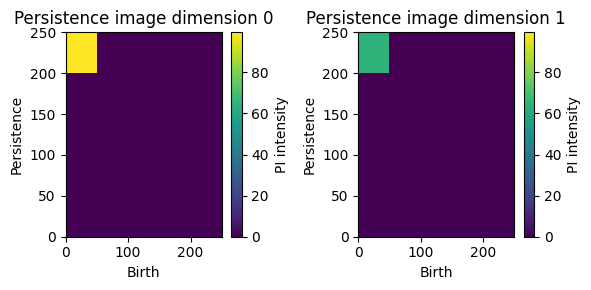

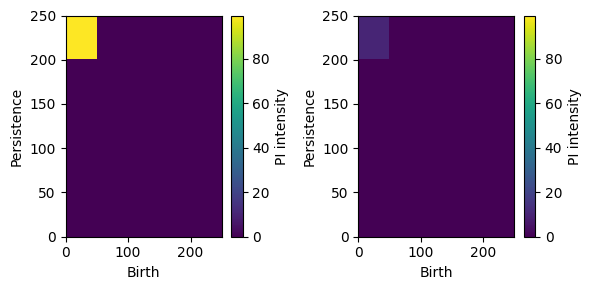

In [50]:
# 8
persistence_dim_0 = replace_inf(complex_8.persistence_intervals_in_dimension(0), 250)
persistence_dim_0
persistence_image_constructor = gd.representations.PersistenceImage(
    bandwidth=10, resolution=[5,5], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2
)
persistence_image_8 = persistence_image_constructor.fit_transform(
    [persistence_dim_0, complex_8.persistence_intervals_in_dimension(1)]
)

# 0
persistence_dim_0_0 = replace_inf(complex_0.persistence_intervals_in_dimension(0), 250)
persistence_dim_0_0
# reuse the same constructor to keep parameters identical
persistence_image_0 = persistence_image_constructor.fit_transform(
    [persistence_dim_0_0, complex_0.persistence_intervals_in_dimension(1)]
)

# --- make all scales (color + axes) the same across all plots ---
to_img = lambda v: np.flip(np.reshape(v, (5,5)), 0)
imgs_all = [
    to_img(persistence_image_8[0]), to_img(persistence_image_8[1]),
    to_img(persistence_image_0[0]), to_img(persistence_image_0[1])
]
vmin = min(img.min() for img in imgs_all)
vmax = max(img.max() for img in imgs_all)
extent = (0, 250, 0, 250)

# Plot for complex_8
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, ax in enumerate(axes):
    ax.set_title(f"Persistence image dimension {i}")
    im = ax.imshow(imgs_all[i], cmap="viridis", extent=extent,
                   aspect="auto", vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax, label="PI intensity")
    ax.set_xlabel("Birth"); ax.set_ylabel("Persistence")
plt.tight_layout()
plt.show()

# Plot for complex_0
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, ax in enumerate(axes):
    im = ax.imshow(imgs_all[2 + i], cmap="viridis", extent=extent,
                   aspect="auto", vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax, label="PI intensity")
    ax.set_xlabel("Birth"); ax.set_ylabel("Persistence")
plt.tight_layout()
plt.show()


In [11]:
def persistence_image_dim_0(image):
    image = 255.0 - image
    complex = gd.CubicalComplex(top_dimensional_cells=image)
    complex.compute_persistence()
    PI =  gd.representations.PersistenceImage(bandwidth=20, resolution=[5, 5], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
    pi = PI.fit_transform([replace_inf(complex.persistence_intervals_in_dimension(0), 250)])
    return pi.flatten()

X_dim0 = cross_validation_parallel(persistence_image_dim_0, images_sample, y_sample)

Shape of the feature matrix: (200, 25)
Done with feature computation, starting classifier
Accuracy:  0.2400 ± 0.0300  | folds: [0.3   0.225 0.225 0.225 0.225]
F1-weight: 0.2117 ± 0.0326 | folds: [0.27025253 0.19843222 0.1825     0.184375   0.22291667]


Training on just dimension 0 has above 10% accuracy, so maybe it will add some accuracy to the dimension 1 classifier.

In [22]:
def persistence_image_dim_0_dim_1(image):
    image = 255.0 - image
    complex = gd.CubicalComplex(top_dimensional_cells=image)
    complex.compute_persistence()
    PI =  gd.representations.PersistenceImage(bandwidth=20, resolution=[5,5], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
    pi = PI.fit_transform([replace_inf(complex.persistence_intervals_in_dimension(0), 250), complex.persistence_intervals_in_dimension(1)])
    return pi.reshape(1, -1)

X_dim0_dim1 = cross_validation_parallel(persistence_image_dim_0_dim_1, images_sample, y_sample)

Shape of the feature matrix: (200, 50)
Done with feature computation, starting classifier
Accuracy:  0.3300 ± 0.0187  | folds: [0.35  0.35  0.3   0.325 0.325]
F1-weight: 0.3081 ± 0.0282 | folds: [0.33841991 0.33497475 0.27108586 0.27857143 0.31763709]


So, slightly better (notice we're feeding the model a vector twice the size now). Now let's see if adding the first nonzero eigenvalues will improve the model.

## Using smallest nonzero eigenvalues

{np.int64(0): {0: 8, 1: 8, 2: 2}, np.int64(1): {0: 71, 1: 86, 2: 25}, np.int64(2): {0: 131, 1: 196, 2: 66}, np.int64(3): {0: 132, 1: 198, 2: 67}, np.int64(4): {0: 133, 1: 200, 2: 68}, np.int64(5): {0: 134, 1: 202, 2: 69}, np.int64(6): {0: 135, 1: 204, 2: 70}, np.int64(7): {0: 136, 1: 206, 2: 71}, np.int64(8): {0: 140, 1: 215, 2: 75}, np.int64(9): {0: 141, 1: 217, 2: 76}, np.int64(10): {0: 143, 1: 222, 2: 79}, np.int64(11): {0: 144, 1: 224, 2: 80}, np.int64(12): {0: 145, 1: 226, 2: 81}, np.int64(13): {0: 146, 1: 228, 2: 82}, np.int64(14): {0: 147, 1: 230, 2: 83}, np.int64(15): {0: 150, 1: 236, 2: 86}, np.int64(16): {0: 151, 1: 238, 2: 87}, np.int64(17): {0: 153, 1: 242, 2: 89}, np.int64(18): {0: 153, 1: 243, 2: 90}, np.int64(19): {0: 154, 1: 245, 2: 91}, np.int64(20): {0: 154, 1: 246, 2: 92}, np.int64(21): {0: 155, 1: 248, 2: 93}, np.int64(22): {0: 156, 1: 250, 2: 94}, np.int64(23): {0: 159, 1: 255, 2: 96}, np.int64(24): {0: 161, 1: 259, 2: 98}, np.int64(25): {0: 163, 1: 263, 2: 100}, n

/tmp/ipykernel_1165899/1672324718.py:9: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  result = pl.smallest_eigenvalue(


{0: {(25, 25): [0.011784069351933203], (25, 51): [0.016027431707287675], (17, 34): [0.013959113890910986], (51, 77): [0.04740459894366605], (0, 8): [0.3244604340033667], (0, 77): [0.7730001321645256], (8, 34): [0.015493099279713422], (8, 42): [0.017135296480033615], (0, 51): [0.3997382567638302], (8, 8): [0.011247458849342083], (0, 0): [1.9999999999999625], (8, 51): [0.01843057521830472], (51, 68): [0.01508235594970122], (0, 68): [0.4217532120886031], (0, 34): [0.38501209635918016], (34, 59): [0.016588791249724767], (17, 25): [0.012238779725714802], (42, 51): [0.01439515013284572], (34, 68): [0.017535828929708376], (8, 77): [0.06431837545831819], (25, 68): [0.018503692451884664], (8, 25): [0.013576738268125933], (25, 34): [0.013455200159016056], (77, 77): [0.011724085691280998], (42, 42): [0.01337600713543715], (34, 51): [0.015226794036625673], (34, 34): [0.012773364687045695], (0, 42): [0.39170663296601976], (0, 59): [0.4027765379785947], (59, 77): [0.04623371391536742], (17, 59): [0.

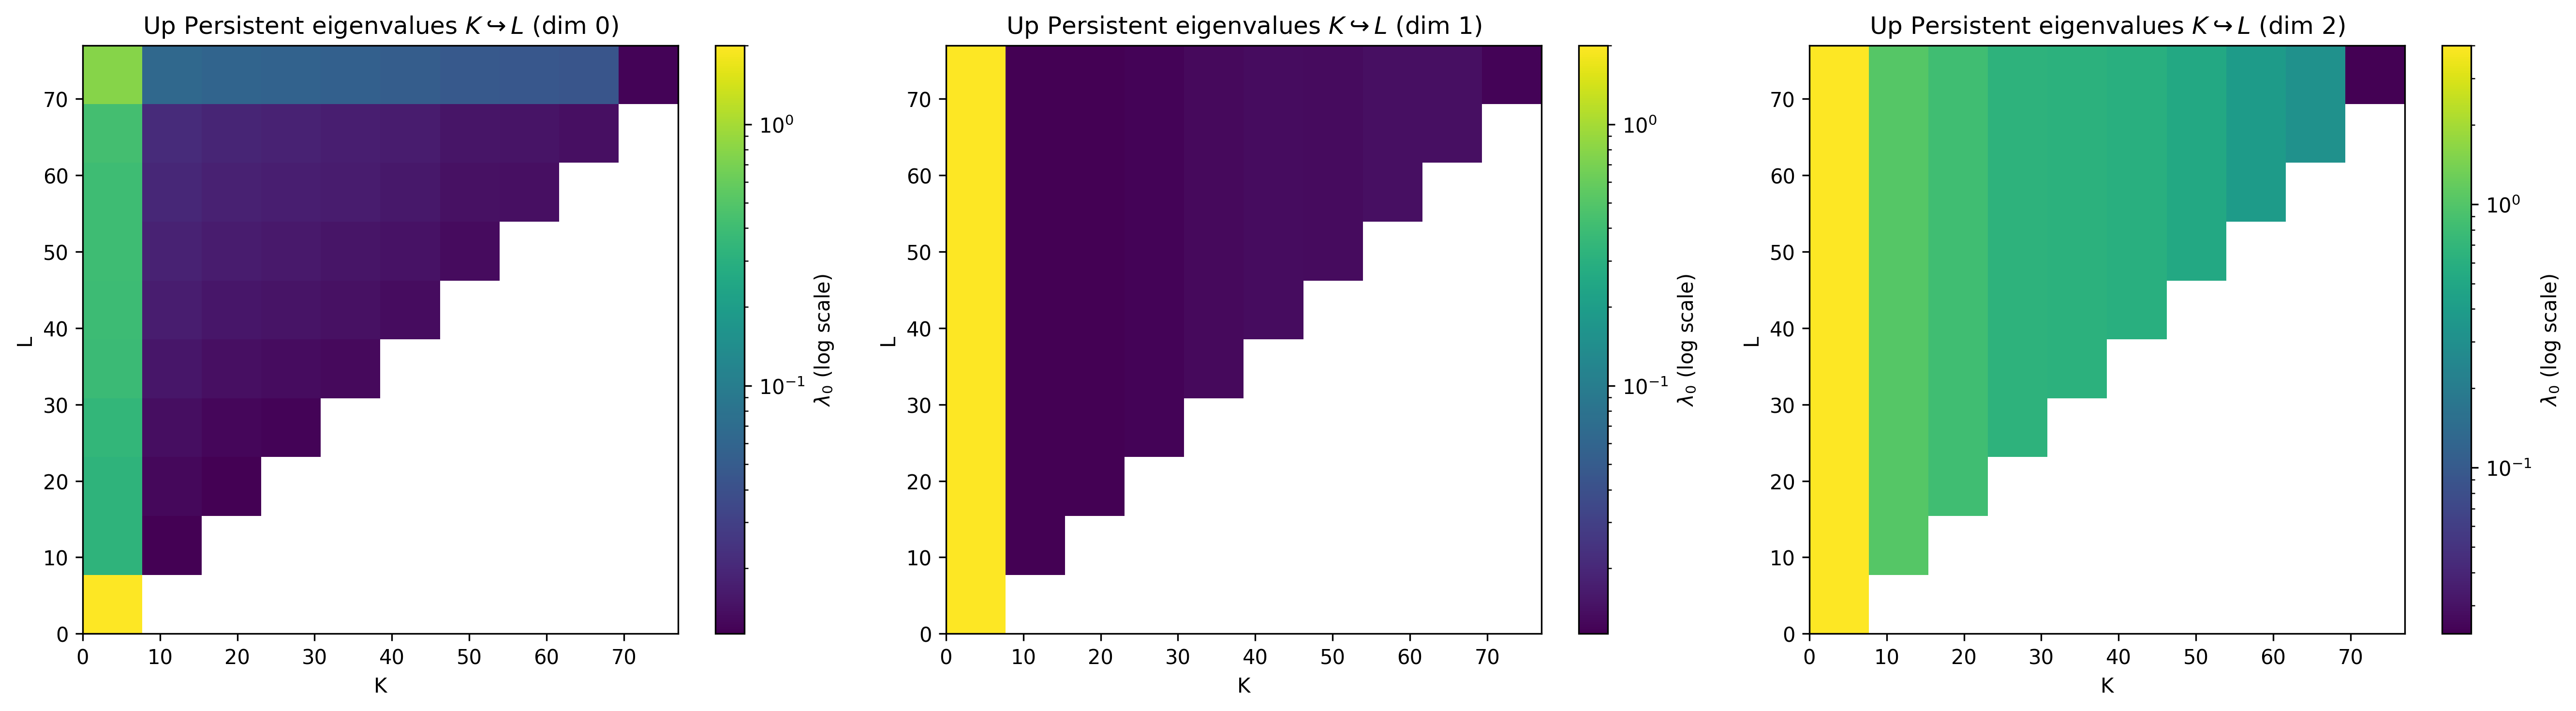

In [16]:
import persistent_laplacians.persistent_laplacians as pl
from persistent_laplacians.cubical_complexes import get_filtration_data
import numpy as np

image = 255.0 - images[1]
boundary_matrices, boundary_maps_index_dict, subsampled_filtration_indices = get_filtration_data(image, num_indices=10)
# print(boundary_matrices)
print(boundary_maps_index_dict)
result = pl.smallest_eigenvalue(
    boundary_matrices,
    boundary_maps_index_dict,
    filtration_subsampling=subsampled_filtration_indices,
    zero_tol=1e-6,
    use_scipy=True,
    use_stepwise_schur=True,
)
print(result)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

dims = [0, 1, 2]
fig, axes = plt.subplots(1, len(dims), figsize=(6*len(dims), 5), dpi=300)
if len(dims) == 1:
    axes = [axes]

for ax, d in zip(axes, dims):
    pts = {k: v for (k, v) in result[d].items() if len(v) >= 1}

    xs = sorted({x for x, y in pts})
    ys = sorted({y for x, y in pts})

    heat = np.full((len(ys), len(xs)), np.nan)
    x_i = {x:i for i,x in enumerate(xs)}
    y_i = {y:i for i,y in enumerate(ys)}
    for (x,y), v in pts.items():
        heat[y_i[y], x_i[x]] = v[0]

    # log scale needs strictly positive values
    heat[~np.isfinite(heat)] = np.nan
    heat[heat <= 0] = np.nan
    vals = heat[np.isfinite(heat)]
    norm = LogNorm(vmin=np.nanmin(vals), vmax=np.nanmax(vals)) if vals.size else None

    im = ax.imshow(
        heat, origin='lower',
        extent=(min(xs), max(xs), min(ys), max(ys)),
        aspect='auto',
        norm=norm  # log color scale
    )
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(r'$\lambda_0$' + (' (log scale)' if norm is not None else ''))

    ax.set_xlabel("K")
    ax.set_ylabel("L")
    ax.set_title(rf'Up Persistent eigenvalues $K \hookrightarrow L$ (dim {d})')

plt.tight_layout()
plt.show()


In [32]:
import persistent_laplacians.persistent_laplacians as pl
from persistent_laplacians.cubical_complexes import get_filtration_data
import numpy as np

def get_nonpersistent_eigenvalues_from_image(image):
    image = 255.0 - image
    boundary_matrices, boundary_maps_index_dict, subsampled_filtration_indices = get_filtration_data(image, num_indices=5)
    print(boundary_matrices)
    print(boundary_maps_index_dict)
    result = pl.smallest_eigenvalue(
        boundary_matrices,
        boundary_maps_index_dict,
        filtration_subsampling=subsampled_filtration_indices,
        zero_tol=1e-6,
        use_scipy=True,
        use_stepwise_schur=False,
    )
    # Filter result to nonpersistent dim 1 features
    nonpersistent_dim1 = [
        (k[0], v)
        for k, v in result[1].items()
        if k[0] == k[1]
    ]
    nonpersistent_dim1.sort(key=lambda x: x[0])
    # Return first element of each or zero if missing
    nonzero_eigs = np.array([vec[0] if vec else 0 for _, vec in nonpersistent_dim1])
    return nonzero_eigs

{1: {'n_rows': 841, 'n_cols': 1624, 'data': array([-1.,  1., -1., ...,  1., -1.,  1.], shape=(3248,)), 'rows': array([225, 226, 226, ..., 839, 839, 840], shape=(3248,)), 'cols': array([ 390,  390,  391, ..., 1622, 1623, 1623], shape=(3248,))}, 2: {'n_rows': 1624, 'n_cols': 784, 'data': array([-1.,  1.,  1., ...,  1.,  1., -1.], shape=(3136,)), 'rows': array([ 390,  447,  418, ..., 1623, 1594, 1595], shape=(3136,)), 'cols': array([166, 166, 166, ..., 783, 783, 783], shape=(3136,))}}
{np.int64(0): {0: 4, 1: 4, 2: 1}, np.int64(1): {0: 107, 1: 159, 2: 55}, np.int64(2): {0: 108, 1: 161, 2: 56}, np.int64(3): {0: 109, 1: 163, 2: 57}, np.int64(4): {0: 110, 1: 165, 2: 58}, np.int64(5): {0: 112, 1: 169, 2: 60}, np.int64(6): {0: 116, 1: 175, 2: 62}, np.int64(7): {0: 117, 1: 177, 2: 63}, np.int64(8): {0: 118, 1: 179, 2: 64}, np.int64(9): {0: 121, 1: 184, 2: 66}, np.int64(10): {0: 122, 1: 187, 2: 67}, np.int64(11): {0: 124, 1: 190, 2: 68}, np.int64(12): {0: 125, 1: 192, 2: 69}, np.int64(13): {0: 12

/tmp/ipykernel_1141161/408624874.py:10: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  result = pl.smallest_eigenvalue(


Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7fde87049300>) }
[2.         0.02679298 0.0244351  0.0239464  0.01172409]
{1: {'n_rows': 841, 'n_cols': 1624, 'data': array([-1.,  1., -1., ...,  1., -1.,  1.], shape=(3248,)), 'rows': array([234, 235, 235, ..., 839, 839, 840], shape=(3248,)), 'cols': array([ 410,  410,  411, ..., 1622, 1623, 1623], shape=(3248,))}, 2: {'n_rows': 1624, 'n_cols': 784, 'data': array([-1.,  1.,  1., ...,  1.,  1., -1.], shape=(3136,)), 'rows': array([ 410,  467,  438, ..., 1623, 1594, 1595], shape=(3136,)), 'cols': array([176, 176, 176, ..., 783, 783, 783], shape=(3136,))}}
{np.int64(0): {0: 8, 1: 8, 2: 2}, np.int64(1): {0: 71, 1: 86, 2: 25}, np.int64(2): {0: 131, 1: 196, 2: 66}, np.int64(3): {0: 132, 1: 198, 2: 67}, np.int64(4): {0: 133, 1: 200, 2: 68}

<Figure size 640x480 with 0 Axes>

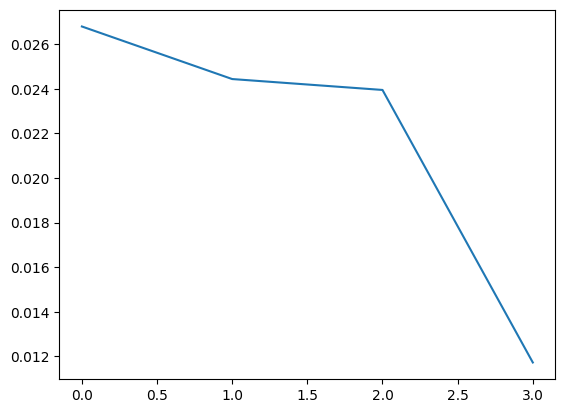

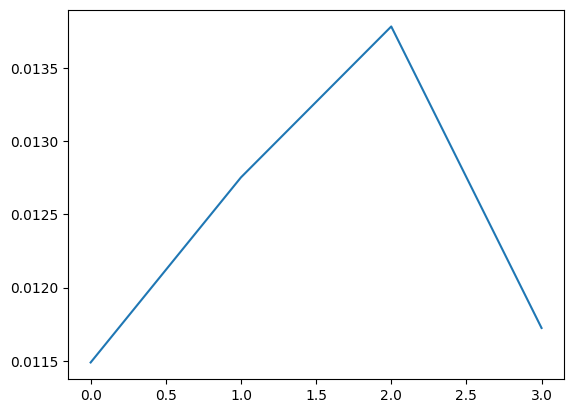

<Figure size 640x480 with 0 Axes>

In [33]:
# 5
nonpersistent_dim1_eigenvalues = get_nonpersistent_eigenvalues_from_image(images[0])
# first eigenvalue is quite large, skipping to see the others better
print(nonpersistent_dim1_eigenvalues)
plt.plot(nonpersistent_dim1_eigenvalues[1:])
plt.figure()

# 0
nonpersistent_dim1_eigenvalues = get_nonpersistent_eigenvalues_from_image(images[1])
plt.plot(nonpersistent_dim1_eigenvalues[1:])
plt.figure()


In [21]:
X_eig_dim1 = cross_validation_parallel(get_nonpersistent_eigenvalues_from_image, images_sample, y_sample)

/tmp/ipykernel_1141161/1919145444.py:8: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  result = pl.smallest_eigenvalue(


Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7fdeec55e7c0>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7fdeec6606c0>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7fdecc5144c0>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.l

Now we will simply append this data to the computation of the persistence image in dimension 1 (I am not including dimension 0 because I suspect that the more data we give the classifier, the harder it will be for it to meaningfully use the persistence data).

In [38]:
def concatenate(features):
    return lambda image: np.concatenate([f(image) for f in features])


In [44]:
dim1_pi_dim_1_nonpersistent_eigen = concatenate([persistence_image_dim_1, get_nonpersistent_eigenvalues_from_image])
X_dim1_pi_dim_1_nonpersistent_eigen = cross_validation_parallel(dim1_pi_dim_1_nonpersistent_eigen, images_sample, y_sample)

/tmp/ipykernel_1114540/1919145444.py:8: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  result = pl.smallest_eigenvalue(


Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7f8d403aa800>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7f8d7f5e8c40>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7f8d1c302f40>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.l

In [52]:
dim0_pi_dim1_pi_dim_1_nonpersistent_eigen = concatenate([persistence_image_dim_0, persistence_image_dim_1, get_nonpersistent_eigenvalues_from_image])
cross_validation_parallel(dim0_pi_dim1_pi_dim_1_nonpersistent_eigen, images_sample, y_sample)

/tmp/ipykernel_1114540/1919145444.py:8: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  result = pl.smallest_eigenvalue(


Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7f8d1c2f5280>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7f8d1c278640>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7f8d1c53ff80>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.l

## Summary of classification results

For only dimension 0 persistence image:
- Accuracy:  0.2400 ± 0.0300  | folds: [0.3   0.225 0.225 0.225 0.225]
- F1-weight: 0.2117 ± 0.0326 | folds: [0.27025253 0.19843222 0.1825     0.184375   0.22291667]

For only dimension 1 persistence image:
- Accuracy:  0.3000 ± 0.0418  | folds: [0.325 0.25  0.25  0.325 0.35 ]
- F1-weight: 0.2407 ± 0.0389 | folds: [0.24883117 0.18375    0.21088023 0.26820818 0.29192719]

For dimension 0 + dimension 1 persistence image: 
- Accuracy:  0.3300 ± 0.0187  | folds: [0.35  0.35  0.3   0.325 0.325]
- F1-weight: 0.3081 ± 0.0282 | folds: [0.33841991 0.33497475 0.27108586 0.27857143 0.31763709]

For dimension 1 nonpersistent eigenvalues: 
- Accuracy:  0.2650 ± 0.0300  | folds: [0.25  0.3   0.25  0.3   0.225]
- F1-weight: 0.2483 ± 0.0356 | folds: [0.21529915 0.2839369  0.24162698 0.29450216 0.2060878 ]

For dimension 1 nonpersistent eigenvalues + dimension 1 persistence image:
- Accuracy:  0.3150 ± 0.0644  | folds: [0.375 0.325 0.2   0.3   0.375]
- F1-weight: 0.2959 ± 0.0557 | folds: [0.31463203 0.29998279 0.19938936 0.29349206 0.37218615]

For dimension 1 nonpersistent eigenvalues + dimension 0 persistence image + dimension 1 persistence image:
- Accuracy:  0.3700 ± 0.0367  | folds: [0.35  0.325 0.35  0.4   0.425]
- F1-weight: 0.3375 ± 0.0453 | folds: [0.29884199 0.29       0.3189899  0.37156593 0.40828283]


## There are lots more things to look into...
- How changing the parameters per feature (num indices, size of image) affects classification accuracy,
- How other dimensions of the eigenvalues do in classification, ...
But it seems that the nonpersistent eigenvalues add some information to the dimension 0 + dimension 1 persistence image classifiers. 


Next, confusion matrix UMAP visualisation of the features to see if there is clear clustering. 

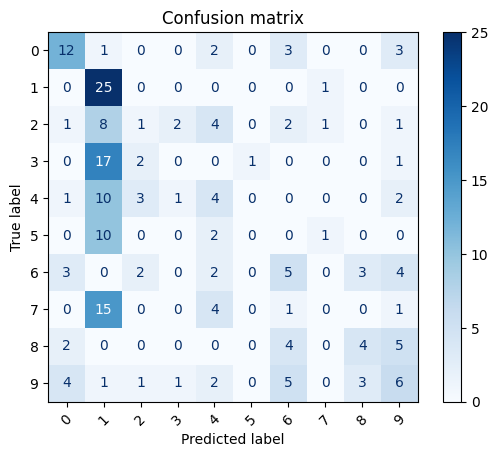

In [52]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def plot_confusion_matrix(X, y_sample):
    # Get out-of-fold predictions
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_pred = cross_val_predict(clf, X, y_sample, cv=cv, n_jobs=-1)

    # Confusion matrix
    cm = confusion_matrix(y_sample, y_pred)

    # Nicely plotted
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_sample))
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion matrix")
    plt.show()

    return X

X = plot_confusion_matrix(X_dim1, y_sample)

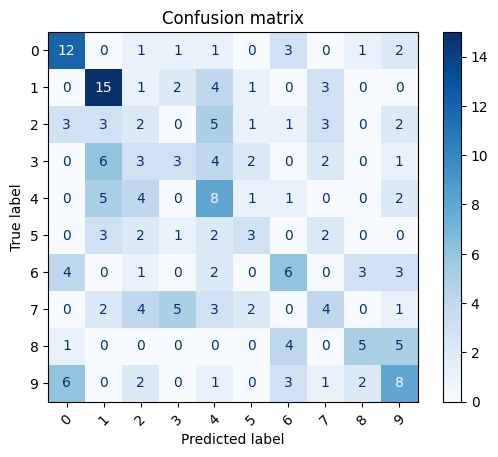

In [53]:
X = plot_confusion_matrix(X_dim0_dim1, y_sample)

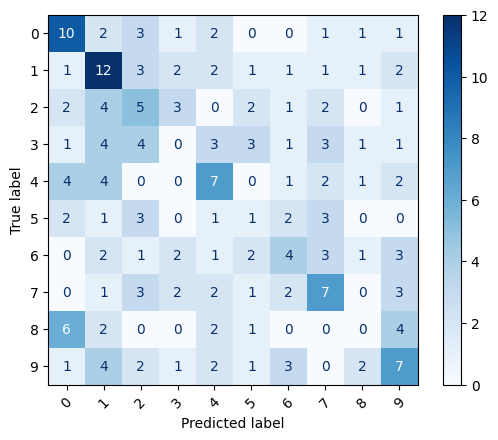

array([[2.        , 0.02679298, 0.0244351 , 0.0239464 , 0.01172409],
       [2.        , 0.01148838, 0.01275342, 0.0137851 , 0.01172409],
       [2.        , 0.03096102, 0.0198729 , 0.01970282, 0.01172409],
       [2.        , 0.01362055, 0.01566604, 0.01443138, 0.01172409],
       [2.        , 0.01317673, 0.01355702, 0.01362355, 0.01172409],
       [2.        , 0.02159036, 0.02231526, 0.02239678, 0.01172409],
       [2.        , 0.02087817, 0.02057306, 0.02219525, 0.01172409],
       [2.        , 0.01744809, 0.01889764, 0.01843021, 0.01172409],
       [2.        , 0.02304668, 0.02417812, 0.02274713, 0.01172409],
       [2.        , 0.01076944, 0.0107023 , 0.01056541, 0.01172409],
       [0.04340082, 0.03931982, 0.04033353, 0.03826493, 0.01172409],
       [2.        , 0.0276586 , 0.03638172, 0.0343865 , 0.01172409],
       [2.        , 0.01473839, 0.01665586, 0.01585661, 0.01172409],
       [2.        , 0.0238079 , 0.02408363, 0.02436787, 0.01172409],
       [2.        , 0.02427827, 0.

In [28]:
plot_confusion_matrix(X_eig_dim1, y_sample)

/home/marmas/personal/repos/persistent-laplacians/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


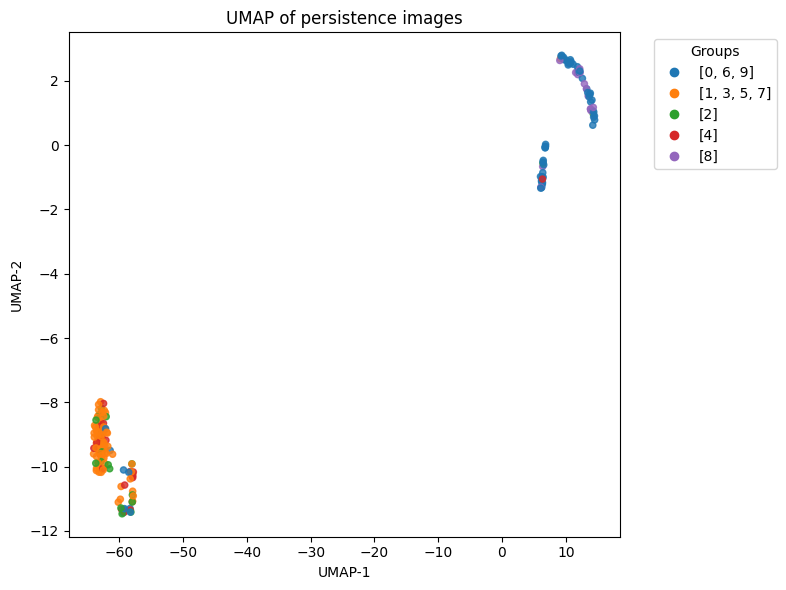

In [63]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap, BoundaryNorm

def umap_grouped_plot(
    X, labels, groups, group_names=None, scale=False,
    n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=42,
    show_unknown=True
):
    # optional scaling
    if scale:
        X = StandardScaler().fit_transform(X)

    # UMAP (2D)
    Z = umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False).fit_transform(X)

    # map label -> group id
    label2group = {int(lbl): gid for gid, grp in enumerate(groups) for lbl in grp}
    g_ids = np.array([label2group.get(int(y), -1) for y in labels], dtype=int)

    # discrete colors: gid k -> color k (fixed)
    n_groups = len(groups)
    base = plt.get_cmap("tab10")
    colors = [base(i % base.N) for i in range(n_groups)]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, n_groups + 0.5, 1), cmap.N)

    plt.figure(figsize=(8, 6))
    known = g_ids != -1
    plt.scatter(Z[known, 0], Z[known, 1], c=g_ids[known],
                cmap=cmap, norm=norm, s=20, alpha=0.8)

    # unknowns (labels not in any group)
    if show_unknown and (~known).any():
        plt.scatter(Z[~known, 0], Z[~known, 1], c="lightgray", s=15, alpha=0.6, label="Other")

    # legend with exact group colors
    handles, texts = [], []
    for gid in range(n_groups):
        h = plt.Line2D([0], [0], marker='o', linestyle='', markersize=6, color=colors[gid])
        handles.append(h)
        name = group_names[gid] if group_names else str(groups[gid])
        texts.append(name)
    if show_unknown and (~known).any():
        handles.append(plt.Line2D([0], [0], marker='o', linestyle='', markersize=6, color='lightgray'))
        texts.append("Other")

    plt.legend(handles, texts, title="Groups", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title("UMAP of persistence images")
    plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    plt.tight_layout(); plt.show()
    return Z

# Z = umap_grouped_plot([get_raw_pixels(x) for x in images_sample], y_sample, [[x] for x in range(0, 10)])
Z = umap_grouped_plot(X_dim1, y_sample, [[0, 6, 9], [1, 3, 5, 7], [2], [4], [8]])


In [56]:
from io import BytesIO
from PIL import Image
import base64
def embeddable_image(data):
    # img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(data, mode='L').resize((50,50), Image.Resampling.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

In [57]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()

Loading BokehJS ...

In [58]:
import pandas as pd
digits_df = pd.DataFrame(Z, columns=('x', 'y'))
digits_df['digit'] = [str(x) for x in y_sample]
digits_df['image'] = list(map(embeddable_image, images_sample))

datasource = ColumnDataSource(digits_df)
color_mapping = CategoricalColorMapper(factors=[str(9 - x) for x in y_sample],
                                       palette=Spectral10)

plot_figure = figure(
    title='UMAP projection of the MNIST dataset',
    width=600,
    height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@digit</span>
    </div>
</div>
"""))

plot_figure.scatter(
    'x',
    'y',
    source=datasource,
    color=dict(field='digit', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
show(plot_figure)

In [82]:
import numpy as np
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, CategoricalColorMapper, HoverTool
from bokeh.palettes import Spectral10
from bokeh.io import output_file, save
# Z: UMAP coords (n_samples, 2)
# X_dim1: flattened persistence images per sample (e.g., 50*50)
def to_img(v, res=(50, 50)):
    a = np.flip(np.reshape(v[:res[0]*res[1]], res).astype(float), 0)
    a -= np.nanmin(a); m = np.nanmax(a)
    if m > 0: a /= m
    return (a * 255).astype(np.uint8)

digits_df = pd.DataFrame(Z, columns=('x', 'y'))
digits_df['digit'] = [str(x) for x in y_sample]
digits_df['image'] = list(map(embeddable_image, images_sample))        # original digit
digits_df['pi0']   = [embeddable_image(to_img(v)) for v in X_dim1]     # first PI image

datasource = ColumnDataSource(digits_df)
factors = sorted(digits_df['digit'].unique().tolist())
color_mapping = CategoricalColorMapper(factors=factors, palette=Spectral10)

plot_figure = figure(
    title='UMAP projection of the MNIST dataset',
    width=600, height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div style="display:flex; gap:8px; align-items:center;">
  <div>
    <img src='@image' width="50" height="50" style='margin:4px; border:1px solid #ccc;'/>
    <div style="text-align:center; font-size:11px;">digit</div>
  </div>
  <div>
    <img src='@pi0' width="50" height="50" style='margin:4px; border:1px solid #ccc;'/>
    <div style="text-align:center; font-size:11px;">PI (first)</div>
  </div>
  <div style="margin-left:6px;">
    <span style='font-size:14px; color:#224499'>Label:</span>
    <span style='font-size:16px'>@digit</span>
  </div>
</div>
"""))

plot_figure.scatter(
    'x', 'y',
    source=datasource,
    color=dict(field='digit', transform=color_mapping),
    line_alpha=0.6, fill_alpha=0.6, size=4
)
save(plot_figure, filename="/tmp/dim1_pi.html")


'/tmp/dim1_pi.html'